In [2]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split

In [108]:
def group_labels(y,ratio,seed=None):
    np.random.seed(seed=seed)
    length = len(y)
    grpwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
    reg_grps = int(length/grpwidth) 
    grp=np.empty(length,dtype=int)
    for i in range(reg_grps):
        b_idx = i * grpwidth
        f_idx = b_idx + grpwidth
        grp[b_idx:f_idx] = np.random.choice(grpwidth,grpwidth,replace=False)
    grp[f_idx:length] = np.random.choice(grpwidth,length-f_idx,replace=False)
    return grp

In [110]:
def split_labels(X,y,grp,binwidth,ratio):
    sel = np.isin(grp,np.arange(int(binwidth*ratio)))
    y_test = y[sel]
    X_test = X[sel]
    sel = np.isin(grp,np.arange(int(binwidth*ratio)),invert=True)
    y_train = y[sel]
    X_train = X[sel]        
    return X_train, X_test, y_train, y_test

In [117]:
def tt_split(X,y,train_ratio,seed=None,val=False):
    X, y = shufflesort(X,y,seed)
    if val:
        valid_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(1-valid_ratio),deno_decimalToFraction(valid_ratio))
        ygrp = group_labels(y,valid_ratio,seed=seed)
        X_train, X_valid, y_train, y_valid = split_labels(X,y,ygrp,binwidth,valid_ratio)

        val_ratio = 0.5
        binwidth = max(deno_decimalToFraction(1-val_ratio),deno_decimalToFraction(val_ratio))
        ygrp = group_labels(y_valid,val_ratio,seed=seed)
        X_val, X_test, y_val, y_test = split_labels(X_valid,y_valid,ygrp,binwidth,val_ratio)

        return X_train, X_val, X_test, y_train, y_val, y_test 
    else:
        test_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(1-test_ratio),deno_decimalToFraction(test_ratio))
        ygrp = group_labels(y,test_ratio,seed=seed)
        X_train, X_test, y_train, y_test = split_labels(X,y,ygrp,binwidth,test_ratio)

        return X_train, X_test, y_train, y_test

In [6]:
from math import floor 
  
# Recursive function to 
# return GCD of a and b 
def gcd(a, b): 
      
    if (a == 0): 
        return b 
    elif (b == 0): 
        return a 
    if (a < b): 
        return gcd(a, b % a) 
    else: 
        return gcd(b, a % b) 

def deno_decimalToFraction(number):
# Returns denominator of fraction converted from decimal   
      
    # Fetch integral value of the decimal 
    intVal = floor(number) 
  
    # Fetch fractional part of the decimal 
    fVal = number - intVal 
  
    # Consider precision value to 
    # convert fractional part to 
    # integral equivalent 
    pVal = 1000000000
  
    # Calculate GCD of integral 
    # equivalent of fractional 
    # part and precision value 
    gcdVal = gcd(round(fVal * pVal), pVal) 
  
    # Calculate num and deno 
    num= round(fVal * pVal) // gcdVal 
    deno = pVal // gcdVal 

#     # Print the fraction 
#     print((intVal * deno) + num, "/", deno) 
  
    return deno 
  

In [105]:
def shufflesort(X,y,seed=None):
# Sorts dataset by label and shuffles labels with the same value
    np.random.seed(seed=seed)
    y_sorted = y.reset_index(drop=True).sort_values()
    idx = y_sorted.index.to_numpy()
    vc = y_sorted.value_counts()
    vals = list(vc[vc > 1].index)
    for val in vals:
        b_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[0])   # First index of value
        f_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[-1])  # Last index of value
        idx[b_idx:f_idx+1] = np.random.permutation(idx[b_idx:f_idx+1])     # Permute order of indices for value
    y_sorted = y_sorted.reindex(idx)
    y = y.iloc[y_sorted.index]
    X = X.iloc[y_sorted.index]
    return X,y

In [112]:
def ou_accuracy(actu,pred,masked=False):
    with open('data/df_2000_2019.pkl','rb') as f:
        dfall = pickle.load(f)
    ou = dfall.loc[actu.index,'Over_Under']
        
    if not((len(actu) == len(pred)) & (len(pred) == len(ou))):
        if (len(actu) != len(pred)):
            raise ValueError(f'Length mismatch among arguments: actual != predicted ({len(actu)} != {len(pred)})')
        else:
            raise ValueError(f'Length mismatch among arguments: predicted != Over/Under ({len(pred)} != {len(ou)})')
    else:
        if not(masked):
            corr = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
            tot = (actu<ou).sum() + (actu>ou).sum()
            return corr/tot
        else:
            mask = abs(pred-ou) >= 4
            actu = actu[mask]
            pred = pred[mask]
            ou = ou[mask]
            corr1 = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
            tot1 = (actu<ou).sum() + (actu>ou).sum()
            return corr1/tot1

In [9]:
def regress(reg,Xtrain,Xtest,ytrain,ytest,cv=5,print_metrics=True,print_coef=True,return_metrics=False):
    robust = RobustScaler()
    sca_train = robust.fit_transform(Xtrain)
    sca_test = robust.transform(Xtest)
    val = cross_validate(reg, sca_train, ytrain, cv=cv, return_estimator=True,
                                scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
                                        'acc':make_scorer(ou_accuracy,greater_is_better=True)})
    acc = (np.mean(val['test_acc']),np.std(val['test_acc']))
    mae = (np.mean(-val['test_mae']),np.std(-val['test_mae']))
    best_estimator = val['estimator'][val['test_mae'].argmax()]

    ypred=best_estimator.predict(sca_test)
    mae_test=mean_absolute_error(ytest,ypred)
    acc_test = ou_accuracy(ytest,ypred)
    sorted_coef = get_coef(best_estimator.coef_,Xtrain.columns)
    if print_metrics:
        print(f'MAE_train = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
        print(-val['test_mae'])
#        print(f'MAE_test = {mae_test:.3f}, Accuracy_test = {acc_test:.3f}')
    if print_coef:
        print(sorted_coef)
    if return_metrics:
        return mae_test,acc_test
    else:
        return

In [10]:
def get_coef(coef_,cols):
    coef = pd.DataFrame(coef_, cols, columns=['LR Coefficient'])
    ind=np.flip(np.argsort(abs(coef_)))
    return coef.iloc[ind]

In [266]:
def cv_model(X,y,gfold,grp,model,scale=True):
    from sklearn.preprocessing import RobustScaler
    mae=[]
    acc=[]
    robust = RobustScaler()
#    for fold, (train_index, valid_index) in enumerate(gfold.split(X, y, grp)):
    for train_index, valid_index in gfold.split(X, y, grp):
        X_train,X_valid = X.iloc[train_index],X.iloc[valid_index]
        y_train,y_valid = y.iloc[train_index],y.iloc[valid_index]
        if scale:
            sca_train = robust.fit_transform(X_train)
            sca_valid = robust.transform(X_valid)
            model.fit(sca_train,y_train)
            y_pred = model.predict(sca_valid)
        else:
            model.fit(X_train,y_train)
            y_pred = model.predict(X_valid)            
        mae.append(mean_absolute_error(y_valid,y_pred))
        acc.append(ou_accuracy(y_valid,y_pred))
    print(model,f'n_splits = {gfold.get_n_splits()}')
    return mae, acc

In [251]:
def print_time():
    ct = datetime.datetime.now()
    print(ct.strftime('%m-%d-%y %H:%M:%S'))
    return

In [368]:
def plot_coef(OLS,p_thresh=None):
    if p_thresh is not None:
        mask = OLS.pvalues[1:] < p_thresh
        params = OLS.params[1:][mask]
        conf_int = OLS.conf_int()[1:][mask]
    else:
        params = OLS.params[1:]
        conf_int = OLS.conf_int()[1:]
        
    err_series = params - conf_int[0]
    coef_df = pd.DataFrame({'coef': params.values,
                            'err': err_series.values,
                            'varname': err_series.index.values
                           })
    fig, ax = plt.subplots(figsize=(8, 5))
    coef_df.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    return

In [ ]:
path = 'data/df_complete.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)

In [11]:
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf']
LR = linear_model.LinearRegression()
robust = RobustScaler()

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

path = 'data/df_2010_2019_5wk.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

In [308]:
train_ratio = 0.70
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
# W/out Pass/Rush Metrics, Scores, Possession, Plays, dome, TOs, TDs
X_train, X_val, X_test, y_train, y_val, y_test  = tt_split(X, y, train_ratio, seed=seed, val=True)

vif = pd.DataFrame()
vif['Features'] = X_train.columns
xarray = sm.add_constant(X_train.values)
vif['VIF Factor'] = [variance_inflation_factor(xarray,i) for i in range(1,len(X_train.columns)+1)]
vif.round(2).sort_values(by='VIF Factor',ascending=False)

,Features,VIF Factor
1,H_Pts_Opp,3.09
3,V_Pts_Opp,2.79
2,V_Pts,2.70
0,H_Pts,2.54
29,dome,2.42
4,H_Off_Pass,2.38
5,V_Off_Pass,2.38
7,V_Off_Rush,1.93
6,H_Off_Rush,1.88
9,V_Def_Pass,1.74


MAE = 10.939117083148364
Validation Accuracy = 0.5372549019607843


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.844
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           9.39e-17
Time:                        09:23:55   Log-Likelihood:                -4857.5
No. Observations:                1215   AIC:                             9781.
Df Residuals:                    1182   BIC:                             9949.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            417.2871    332.326      1.256      0.209    -234.727    1069.301
H_Pts              0.2745      0.114      2.398      0.017       0.050       0.499
H_Pts_Opp          0.0602      0.132      0.456      0.649      -0.199       0.319
V_Pts             -0.0291      0.111     -0.262      0.793      -0.247       0.189
V_Pts_Opp         -0.1621      0.124     -1.309      0.191      -0.405       0.081
H_Off_Pass         0.0207      0.014      1.525      0.128      -0.006       0.047
V_Off_Pass         0.0520      0.014      3.835      0.000       0.025       0.079
H_Off_Rush         0.0082      0.019      0.436      0.663      -0.029       0.045
V_Off_Rush         0.0353      0.019      1.825      0.068      -0.003       0.073
H_Def_Pass         0.0106      0.014      0.772      0.440      -0.016       0.038
V_Def_Pass         0.0383      0.014      2.797      0.005       0.011       0.065
H_Def_Rush         0.0452      0.020      2.299      0.022       0.007       0.084
V_Def_Rush         0.0350      0.019      1.841      0.066      -0.002       0.072
H_FG_Pct          -3.6663      3.258     -1.125      0.261     -10.059       2.726
V_FG_Pct           3.6502      3.070      1.189      0.235      -2.373       9.674
H_RZ_Def_Pct      -2.9965      4.048     -0.740      0.459     -10.939       4.946
V_RZ_Def_Pct      14.7576      3.979      3.709      0.000       6.951      22.564
H_Yds_Pen          0.0200      0.031      0.653      0.514      -0.040       0.080
V_Yds_Pen          0.0124      0.031      0.402      0.688      -0.048       0.073
H_Sacks_Def        0.5434      0.628      0.865      0.387      -0.689       1.775
V_Sacks_Def        0.4357      0.632      0.689      0.491      -0.805       1.676
H_Tackles_Loss     0.2680      0.434      0.618      0.537      -0.583       1.119
V_Tackles_Loss     0.3215      0.425      0.756      0.450      -0.513       1.156
H_Kickret         -0.0654      0.076     -0.865      0.387      -0.214       0.083
V_Kickret         -0.0032      0.070     -0.046      0.963      -0.140       0.133
H_Puntret          0.0803      0.101      0.795      0.427      -0.118       0.279
V_Puntret         -0.2338      0.101     -2.304      0.021      -0.433      -0.035
Temperature       -0.0054      0.027     -0.201      0.841      -0.059       0.048
Wind              -0.2588      0.085     -3.029      0.003      -0.426      -0.091
grass             -1.4365      0.926     -1.551      0.121      -3.253       0.380
dome               0.0665      1.366      0.049      0.961      -2.614       2.747
Week              -0.1137      0.130     -0.878      0.380      -0.368       0.140
Year              -0.2114      0.165     -1.283      0.200      -0.535       0.112
==============================================================================
Omnibus:        

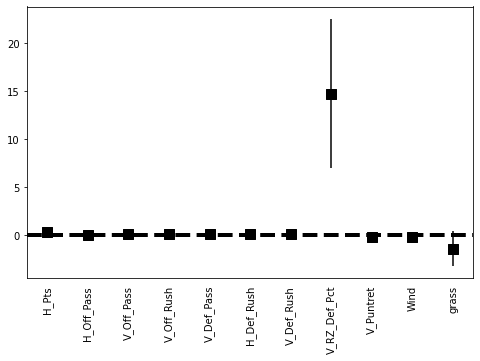

In [369]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
OLS = sm.OLS(y_train, X_train).fit()
ypred=OLS.predict(X_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
#get_coef(LR.coef_,X_train.columns)
plot_coef(OLS,p_thresh=0.15)
OLS.summary()

MAE = 10.939117083148581
Validation Accuracy = 0.5372549019607843


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.844
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           9.39e-17
Time:                        09:24:44   Log-Likelihood:                -4857.5
No. Observations:                1215   AIC:                             9781.
Df Residuals:                    1182   BIC:                             9949.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.0205      0.605     72.771      0.000      42.834      45.207
H_Pts              1.8666      0.778      2.398      0.017       0.339       3.394
H_Pts_Opp          0.4091      0.898      0.456      0.649      -1.353       2.171
V_Pts             -0.2212      0.843     -0.262      0.793      -1.876       1.434
V_Pts_Opp         -1.1996      0.916     -1.309      0.191      -2.998       0.598
H_Off_Pass         1.2134      0.796      1.525      0.128      -0.348       2.775
V_Off_Pass         3.1482      0.821      3.835      0.000       1.538       4.759
H_Off_Rush         0.2979      0.683      0.436      0.663      -1.041       1.637
V_Off_Rush         1.2836      0.704      1.825      0.068      -0.097       2.664
H_Def_Pass         0.5406      0.700      0.772      0.440      -0.833       1.914
V_Def_Pass         1.9761      0.706      2.797      0.005       0.590       3.362
H_Def_Rush         1.4779      0.643      2.299      0.022       0.216       2.739
V_Def_Rush         1.2401      0.674      1.841      0.066      -0.081       2.562
H_FG_Pct          -0.6111      0.543     -1.125      0.261      -1.676       0.454
V_FG_Pct           0.6318      0.531      1.189      0.235      -0.411       1.674
H_RZ_Def_Pct      -0.5141      0.695     -0.740      0.459      -1.877       0.849
V_RZ_Def_Pct       2.3302      0.628      3.709      0.000       1.098       3.563
H_Yds_Pen          0.3787      0.580      0.653      0.514      -0.760       1.517
V_Yds_Pen          0.2159      0.537      0.402      0.688      -0.839       1.270
H_Sacks_Def        0.6520      0.753      0.865      0.387      -0.826       2.130
V_Sacks_Def        0.5228      0.759      0.689      0.491      -0.966       2.012
H_Tackles_Loss     0.4020      0.650      0.618      0.537      -0.874       1.678
V_Tackles_Loss     0.5787      0.766      0.756      0.450      -0.923       2.081
H_Kickret         -0.4380      0.506     -0.865      0.387      -1.431       0.555
V_Kickret         -0.0215      0.467     -0.046      0.963      -0.938       0.895
H_Puntret          0.3662      0.461      0.795      0.427      -0.538       1.270
V_Puntret         -1.1146      0.484     -2.304      0.021      -2.064      -0.165
Temperature       -0.1467      0.731     -0.201      0.841      -1.582       1.288
Wind              -2.5881      0.854     -3.029      0.003      -4.264      -0.912
grass             -1.4365      0.926     -1.551      0.121      -3.253       0.380
dome               0.0665      1.366      0.049      0.961      -2.614       2.747
Week              -0.6821      0.777     -0.878      0.380      -2.207       0.843
Year              -1.0569      0.824     -1.283      0.200      -2.674       0.560
==============================================================================
Omnibus:        

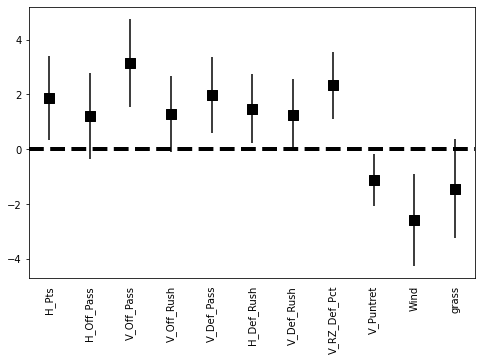

In [371]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
sca_train = X_train
sca_train[sca_train.columns] = robust.fit_transform(sca_train[sca_train.columns])
sca_train = sm.add_constant(sca_train)
sca_val = robust.transform(X_val)
sca_val = sm.add_constant(sca_val)
OLS = sm.OLS(y_train, sca_train).fit()
ypred=OLS.predict(sca_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
plot_coef(OLS,p_thresh=0.15)
OLS.summary()

In [269]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
LR = linear_model.LinearRegression()
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,LR,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 05:59:08
LinearRegression() n_splits = 5
MAE: 10.767±0.254
acc: 0.520±0.037


In [372]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8,max_features=8,
                                        criterion='mae')
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,RF,scale=False)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 09:42:45
RandomForestRegressor(criterion='mae', max_depth=8, max_features=8,
                      random_state=37) n_splits = 5
MAE: 10.688±0.063
acc: 0.530±0.015
V_Off_Pass                0.052543
V_Pts                     0.045974
V_Def_Pass                0.042647
V_RZ_Def_Pct              0.037533
H_Pts                     0.037109
H_Off_Rush                0.035412
V_Puntret                 0.034564
H_Off_Pass                0.034040
H_Def_Pass                0.031930
H_Puntret                 0.031561
H_RZ_Def_Pct              0.030387
V_Off_Rush                0.030282
H_Def_Rush                0.029602
H_Pts_Opp                 0.029478
Temperature               0.026922
H_Kickret                 0.026653
V_Kickret                 0.026308
V_Def_Rush                0.025960
V_FG_Pct                  0.023781
V_Tackles_Loss            0.023251
V_Yds_Pen                 0.023152
V_Pts_Opp                 0.022885
Wind                      0.022394
H_Tackles_Loss        

In [373]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8,
                                        criterion='mae')
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,RF,scale=False)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 09:44:16
RandomForestRegressor(criterion='mae', max_depth=8, random_state=37) n_splits = 5
MAE: 10.703±0.108
acc: 0.523±0.028
V_Off_Pass                0.065834
V_Def_Pass                0.052573
H_Off_Pass                0.043338
V_Pts                     0.041548
V_Puntret                 0.041120
H_Pts                     0.040080
H_Off_Rush                0.037102
Temperature               0.037060
V_Off_Rush                0.036036
H_Puntret                 0.035185
H_Pts_Opp                 0.031473
H_Def_Pass                0.029406
H_Kickret                 0.029169
V_RZ_Def_Pct              0.028571
V_Kickret                 0.028018
H_RZ_Def_Pct              0.027868
H_Yds_Pen                 0.027679
V_Def_Rush                0.027581
V_Yds_Pen                 0.027226
Wind                      0.026849
H_FG_Pct                  0.024934
H_Def_Rush                0.023231
V_Pts_Opp                 0.023096
V_Sacks_Def               0.020049
V_Tackles_Loss           

In [376]:
print_time()
seed = 37
train_ratio = 0.70
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8, max_features=8,
                                        criterion='mae')
RF.fit(X_train, y_train)
ypred = RF.predict(X_val)
mae = mean_absolute_error(y_val, ypred) 
acc = ou_accuracy(y_val, ypred)
print('MAE: {0:.3f}'.format(mae))
print('acc: {0:.3f}'.format(acc))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 10:02:10
MAE: 10.803
acc: 0.518
V_Off_Pass                0.061478
V_Def_Pass                0.039852
H_Off_Pass                0.039629
V_Puntret                 0.037195
H_Pts                     0.037179
V_RZ_Def_Pct              0.036089
H_Pts_Opp                 0.033668
V_Pts_Opp                 0.033090
V_Pts                     0.032966
H_Def_Pass                0.032807
Wind                      0.031999
H_Puntret                 0.030565
H_Off_Rush                0.029399
Temperature               0.028285
H_Def_Rush                0.028053
V_Kickret                 0.027586
V_Off_Rush                0.027398
V_Def_Rush                0.026224
V_Yds_Pen                 0.024733
H_RZ_Def_Pct              0.023829
H_Kickret                 0.023662
H_Yds_Pen                 0.022941
Week                      0.021434
V_FG_Pct                  0.019506
H_Sacks_Def               0.019315
V_Tackles_Loss            0.018633
H_Tackles_Loss            0.016869
H_FG_Pct      

In [291]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
lasso = Lasso(alpha = 0.009, normalize=True)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,lasso,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 06:41:28
Lasso(alpha=0.009, normalize=True) n_splits = 5
MAE: 10.715±0.197
acc: 0.523±0.030


In [262]:
print_time()
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(alpha = 0.68, normalize=True)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,ridge,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 05:39:29
Ridge(alpha=0.68, normalize=True) n_splits = 5
MAE: 10.693±0.147
acc: 0.527±0.022


In [ ]:
# Random Forest
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import graphviz
train_ratio = 0.85
param_grid = [{'n_estimators' : [200, 400, 800, 1000], 'max_depth' : [3, 6, 8, 10], 
              'max_features' : [4, 8, 16, 32, 'auto']}]
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=37)
RF = ensemble.RandomForestRegressor(random_state=77,criterion='mae')
grid_search = GridSearchCV(RF, param_grid, cv=5, 
                           scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False)},refit='mae')
grid_search.fit(X_train, y_train)

In [683]:
import graphviz
from sklearn.tree import export_graphviz
for i in range(10):
    ind = i*80
    dot_data = export_graphviz(grid_search.best_estimator_.estimators_[i], 
                               out_file=f'plots/RF_Trees/tree{i+1}.dot',
                               filled=True, rounded=True, feature_names=X.columns)

In [281]:
print_time()
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
lasso = Lasso(normalize=True)
#alphas=np.logspace(-4, 0, 17)
alphas=np.logspace(-2.5, -2, 10)
param_grid = [{'alpha' : alphas}]
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
print(lasso,f'n_splits = {GKF.get_n_splits()}')
GS = GridSearchCV(lasso, param_grid, cv=GKF.split(X_train,y_train,groups), scoring=scoring, refit='mae')
GS.fit(X_train, y_train)
GS.cv_results_

12-23-20 06:34:12
Lasso(normalize=True) n_splits = 5


{'mean_fit_time': array([0.01234055, 0.01287851, 0.01312771, 0.00820441, 0.00967746,
        0.0136869 , 0.01172776, 0.01011806, 0.00851989, 0.01162357]),
 'std_fit_time': array([0.00231181, 0.00128996, 0.00413259, 0.00114669, 0.00324002,
        0.00180229, 0.00277348, 0.00109844, 0.00126114, 0.00274582]),
 'mean_score_time': array([0.01749578, 0.0190661 , 0.0217063 , 0.01221418, 0.01590095,
        0.0185637 , 0.01650739, 0.01368437, 0.01187415, 0.01777945]),
 'std_score_time': array([0.00134866, 0.00289884, 0.01135463, 0.00028763, 0.00312797,
        0.00139106, 0.00310656, 0.00188267, 0.00023649, 0.00438768]),
 'param_alpha': masked_array(data=[0.0031622776601683794, 0.003593813663804626,
                    0.004084238652674522, 0.004641588833612777,
                    0.00527499706370262, 0.005994842503189409,
                    0.006812920690579615, 0.007742636826811269,
                    0.008799225435691074, 0.01],
              mask=[False, False, False, False, False, Fal

In [388]:
print_time()
from sklearn.linear_model import Lasso
train_ratio = 0.70
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','grass','sportturf','matrixturf','dome','fieldturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, val=True,seed=seed)
sca_train = robust.fit_transform(X_train)
sca_val = robust.transform(X_val)
#lasso = Lasso(alpha = 0.007, normalize=True)
lasso = Lasso(alpha = 0.011, normalize=True)
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
lasso.fit(sca_train,y_train)
ypred=lasso.predict(sca_val)
mae=mean_absolute_error(y_val,ypred)
acc=ou_accuracy(y_val,ypred)
sorted_coef = get_coef(lasso.coef_,X_train.columns)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
print(sorted_coef)
plot_coef()

12-23-20 10:14:08
MAE = 10.817601401649306
Validation Accuracy = 0.5215686274509804
                LR Coefficient
Wind                 -2.346999
V_Off_Pass            2.100770
H_Pts                 1.734814
V_RZ_Def_Pct          1.590835
H_Off_Pass            0.930776
V_Def_Pass            0.917549
V_Puntret            -0.567506
H_Def_Rush            0.531299
V_Pts                 0.428116
V_Off_Rush            0.257821
Week                 -0.206921
V_FG_Pct              0.094634
H_Sacks_Def           0.046750
H_Def_Pass            0.029045
H_Tackles_Loss        0.008790
V_Pts_Opp             0.000000
H_Off_Rush            0.000000
H_Pts_Opp             0.000000
Year                 -0.000000
V_Def_Rush            0.000000
H_FG_Pct             -0.000000
H_Yds_Pen             0.000000
V_Yds_Pen             0.000000
V_Sacks_Def           0.000000
V_Tackles_Loss        0.000000
H_Kickret            -0.000000
V_Kickret             0.000000
H_Puntret             0.000000
Temperature      

In [277]:
print_time()
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(normalize=True)
#alphas=np.logspace(-4, 0, 17)
alphas=np.logspace(-0.5, 0, 10)
param_grid = [{'alpha' : alphas}]
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
print(ridge,f'n_splits = {GKF.get_n_splits()}')
GS = GridSearchCV(ridge, param_grid, cv=GKF.split(X_train,y_train,groups), scoring=scoring, refit='mae')
GS.fit(X_train, y_train)
GS.cv_results_

12-23-20 06:27:40
Ridge(normalize=True) n_splits = 5


{'mean_fit_time': array([0.00662355, 0.00620189, 0.00659041, 0.01019902, 0.00662813,
        0.00459962, 0.00493422, 0.00523987, 0.00508809, 0.00470967]),
 'std_fit_time': array([1.06873087e-03, 4.70826378e-04, 7.32216356e-04, 4.75401948e-03,
        2.31460558e-03, 8.30806341e-05, 5.55422771e-04, 7.04808850e-04,
        4.76338197e-04, 1.33575477e-04]),
 'mean_score_time': array([0.01678848, 0.01608653, 0.01694975, 0.02073178, 0.01406131,
        0.01187768, 0.01256819, 0.0118567 , 0.01250119, 0.01171784]),
 'std_score_time': array([0.00140863, 0.00159323, 0.00050524, 0.00208965, 0.00211319,
        0.00056319, 0.00184516, 0.00058217, 0.00059206, 0.00045904]),
 'param_alpha': masked_array(data=[0.31622776601683794, 0.35938136638046275,
                    0.4084238652674521, 0.46415888336127786,
                    0.5274997063702618, 0.599484250318941,
                    0.6812920690579612, 0.774263682681127,
                    0.8799225435691069, 1.0],
              mask=[False, F

In [14]:
train_ratio = 0.85
mae = np.empty(7)
acc = np.empty(7)
ou = np.empty(7)
acc_ext = np.empty(7)
for n in range(7):
    path = 'data/df_working'+str(n+1)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = dfgame['Tot_Pts']
    XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX = XX.drop(turf,axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    m, a = regress(LR,XX_train,XX_test,yy_train,yy_test,
                   print_metrics=False,print_coef=False,return_metrics=True)
    ou[n] = mean_absolute_error(yy_test,dfgame.loc[XX_test.index,'Over/Under'])
    mae[n] = m
    acc[n] = a
print(mae)
print(acc)
print(ou-mae)

[11.34933801 11.16744056 10.48705836 10.59635947 11.09379895 10.69871393
 10.22553897]
[0.45892351 0.53012048 0.50645161 0.51590106 0.54509804 0.55339806
 0.51442308]
[-0.83544912 -0.44422627 -0.28513529 -0.24095878 -0.50567634 -0.25767619
 -0.40714275]
